In [22]:
import os
import re
import sys
import json
import config
import random
import pickle
import spotipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from openTSNE import TSNE as openTSNE
from scipy.spatial.distance import cdist
from sklearn.dummy import DummyRegressor
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from IPython.display import SVG, display, Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, SpectralClustering, DBSCAN, OPTICS, Birch, KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_score, pairwise_distances, davies_bouldin_score, calinski_harabasz_score


# warnings.filterwarnings("ignore")

In [24]:
# Credentials
os.environ["SPOTIPY_CLIENT_ID"] = config.SPOTIPY_CLIENT_ID
os.environ["SPOTIPY_CLIENT_SECRET"] = config.SPOTIPY_CLIENT_SECRET
os.environ['SPOTIPY_REDIRECT_URI'] = config.SPOTIPY_REDIRECT_URI  # Needed for user authorization

# Defining scope to read user playlist and write playlist to user
scope = 'user-library-read user-follow-read playlist-modify-private playlist-modify'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [3]:
df = pd.read_csv('data/Playlist_Feats.csv')
df

name     pid  danceability    energy       key  loudness  \
0            Throwbacks       0      0.664077  0.781077  5.038462 -4.891212   
1      Awesome Playlist       1      0.492382  0.695923  4.461538 -8.107974   
2               korean        2      0.671062  0.692953  5.000000 -4.875594   
3                   mat       3      0.514349  0.620901  5.103175 -9.618754   
4                   90s       4      0.576235  0.650418  3.352941 -7.634529   
...                 ...     ...           ...       ...       ...       ...   
19995         gang gang  115995      0.804615  0.529026  4.205128 -8.164179   
19996             Chaos  115996      0.688900  0.695500  5.700000 -8.232650   
19997       Spring 2014  115997      0.646571  0.603214  5.357143 -6.890929   
19998            autumn  115998      0.549943  0.562457  5.114286 -8.666057   
19999             ChIlL  115999      0.680809  0.576838  5.139706 -6.657647   

           mode  speechiness  acousticness  instrumentalness  liveness  \
0      0.692308     0.103698      0.083674          0.000674  0.187087   
1      0.538462     0.091010      0.162227          0.223708  0.179344   
2      0.515625     0.096425      0.269100          0.000638  0.168894   
3      0.714286     0.067004      0.273514          0.203148  0.188278   
4      0.823529     0.041218      0.177189          0.081759  0.166524   
...         ...          ...           ...               ...       ...   
19995  0.589744     0.219638      0.217947          0.008621  0.166574   
19996  0.400000     0.104215      0.243258          0.225892  0.151770   
19997  0.714286     0.078743      0.227477          0.024347  0.146629   
19998  0.657143     0.065520      0.273361          0.018066  0.161580   
19999  0.625000     0.121825      0.258820          0.002936  0.146857   

        valence       tempo    duration_ms  time_signature  
0      0.642750  121.157500  221777.461538        4.000000  
1      0.476667  124.987128  298837.641026        3.769231  
2      0.565078  114.595984  219373.953125        4.000000  
3      0.451258  125.523048  229575.055556        3.952381  
4      0.490294  127.725412  255014.352941        3.941176  
...         ...         ...            ...             ...  
19995  0.363818  129.452256  230348.358974        4.000000  
19996  0.717800  135.314300  283091.000000        4.050000  
19997  0.442571  125.139071  268988.928571        4.000000  
19998  0.390406  114.144886  237814.542857        3.971429  
19999  0.456876  116.815824  228286.132353        3.963235  

[20000 rows x 15 columns]

In [ ]:
# # Get all favorite songs from current user and save them to lists to construct dataframe
# tracks = sp.current_user_saved_tracks()

# song = []
# artist = []
# uri = []

# #First pass of the saved tracks
# for i in tracks['items']:
#     song.append(i['track']['name'])
#     artist.append(i['track']['artists'][0]['name'])
#     uri_id = i['track']['uri']
#     uri.append(re.search('(^spotify:track:([^\s]+))', uri_id).groups()[1])

# # Keep looking in tracks for the rest of the saved tracks, they are paginated
# while tracks['next']:
#     tracks = sp.next(tracks)
#     for i in tracks['items']:
#         song.append(i['track']['name'])
#         artist.append(i['track']['artists'][0]['name'])
#         uri_id = i['track']['uri']
#         uri.append(re.search('(^spotify:track:([^\s]+))', uri_id).groups()[1])

# # Create a dataframe from info extracted above, song, artist and uri
# fav_songs_df = pd.DataFrame(
#     {'song': song,
#      'artist': artist,
#      'uri': uri
#     })
# fav_songs_df.head()

In [4]:
# # Extract audio features from each song and create a dataframe
# appended_df = []
# for i in uri:
#     appended_df.append(pd.DataFrame(sp.audio_features(i)[0], index=[i,]))
# uri_df = pd.concat(appended_df)
# uri_df = uri_df.drop(['uri'], axis=1)
# uri_df = uri_df.reset_index()
# uri_df = uri_df.rename(columns={"index": "uri"})

# fav_songs_feats_df = pd.merge(fav_songs_df, uri_df, on="uri")
fav_songs_feats_df = pd.read_csv('data/fav_songs_feats_df.csv')
fav_songs_feats_df.head()

song           artist                     uri  \
0  Bendita Diabla - Apaga La Luz           E-Lhoy  0OxR238zEmOy20sSBbHgyK   
1  Sinnerman - Sofi Tukker Remix      Nina Simone  6Au1l0egQFYxbnCZxakoOL   
2             Lied vom Scheitern        Die Ärzte  3PUryKL6Jme3BlX95tutYn   
3                          Junge        Die Ärzte  10waMsh44ojvTwXAIy213n   
4              Müssen nur wollen  Wir Sind Helden  1e79l5iRNvf4q9YXjt1Mn8   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.714   0.535    1    -7.149     0       0.0549       0.54500   
1         0.795   0.764   11    -7.463     0       0.0400       0.41100   
2         0.523   0.971    3    -4.683     1       0.0988       0.00313   
3         0.563   0.792   10    -4.885     0       0.0350       0.05320   
4         0.706   0.672    4    -3.903     1       0.0296       0.11300   

   instrumentalness  liveness  valence    tempo            type  \
0          0.000000    0.0859    0.619  130.045  audio_features   
1          0.010500    0.0912    0.156  124.027  audio_features   
2          0.000002    0.3800    0.381  144.956  audio_features   
3          0.000003    0.1070    0.176  105.463  audio_features   
4          0.000000    0.1670    0.829  125.941  audio_features   

                       id                                         track_href  \
0  0OxR238zEmOy20sSBbHgyK  https://api.spotify.com/v1/tracks/0OxR238zEmOy...   
1  6Au1l0egQFYxbnCZxakoOL  https://api.spotify.com/v1/tracks/6Au1l0egQFYx...   
2  3PUryKL6Jme3BlX95tutYn  https://api.spotify.com/v1/tracks/3PUryKL6Jme3...   
3  10waMsh44ojvTwXAIy213n  https://api.spotify.com/v1/tracks/10waMsh44ojv...   
4  1e79l5iRNvf4q9YXjt1Mn8  https://api.spotify.com/v1/tracks/1e79l5iRNvf4...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/0OxR...       210000   
1  https://api.spotify.com/v1/audio-analysis/6Au1...       232632   
2  https://api.spotify.com/v1/audio-analysis/3PUr...       209187   
3  https://api.spotify.com/v1/audio-analysis/10wa...       187533   
4  https://api.spotify.com/v1/audio-analysis/1e79...       215747   

   time_signature  
0               4  
1               4  
2               4  
3               4  
4               4

In [5]:
feat_cols = ['pid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
feat_cols_user = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

# The Data

For this project we are using The Million Playist Dataset, as it name implies,the dataset consists of one million playlists and each playlists contains n number of songs and some metadata is included as well such as name of the playlist, duration, number of songs, number of artists, etc.

It is created by sampling playlists from the billions of playlists that Spotify users have created over the years. Playlists that meet the following criteria were selected at random:

 * Created by a user that resides in the United States and is at least 13 years old
 * Was a public playlist at the time the MPD was generated
 * Contains at least 5 tracks
 * Contains no more than 250 tracks
 * Contains at least 3 unique artists
 * Contains at least 2 unique albums
 * Has no local tracks (local tracks are non-Spotify tracks that a user has on their local device)
 * Has at least one follower (not including the creator)
 * Was created after January 1, 2010 and before December 1, 2017
 * Does not have an offensive title
 * Does not have an adult-oriented title if the playlist was created by a user under 18 years of age
 
As you can imagine a million anything is too large to handle and we are going to be using 2% of the data (20,000 playlists) to create the models and the scaling to an AWS instance.
 
## Enhancing the data
Since this dataset is released by Spotify, it already includes a track id that can be used to generate API calls and access the multiple information that is provided from Spotify for a given song, artist or user.

These are some of the features that are available to us for each song and we are going to use them to enhance our dataset and to help matching the user's favorite playlist.

Some of the available features are the following, they are measured mostly in a scale of 0-1:
 - Danceability: a measurement of how "danceable" a given song is.
 - Energy: perceptual measure of intensity and activity.
 - Intrumentalness: whether a song contains no vocals (pure instrumental).
 - Liveness: presence of audience in a song i.e.: on a concert.
 - Loudness: How loud a song is in dB.
 - Mode: Minor or Major mode.
 - Speechiness: presence of words in a song.
 - Tempo: Beats per minute (BPM)
 
## Shapping the data
The 20,000 playlists were parsed through the Spotify API to retrieve the audio features for each son in each playlist, this in itself is a very time consuming operation due to the latency of the API calls, to give you an idea, 40 hours were needed to collect the features for all songs in each playlist.

Once the features were collected, the average of them were taken to have the audio features for the playlist with this, we reduced the dataset to a single row per playlist with a good feature representation of the contents of them.


# Supervised Approach
One of the first things we did was to explore a supervised method but that did not turned out well because of the data we collected does not have any labels, yes, it is true that each playlist has a label in the form of a playlist name but the target songs that we are using are the user's favorite songs which is nothing but a big playlist of songs that the user has liked in the past and it is not labeled in any way. Because of this, we found out really soon that a supervised method was outside of our hands.

One thing that can be done in the future is to read the user's self created playlists or liked playlist and use the names of those playlists and then create a supervised learning model.

In [ ]:
df.T

In [ ]:
# Transpose df to have playlists as features - This is going to be X
X = df[feat_cols].set_index('pid').T
# Mean of the features of the user's fav songs - This is going to be y
y = fav_songs_feats_df[feat_cols_user].mean()

# Split data for training and testing
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = StandardScaler().fit_transform(X_train_raw)
X_test  = StandardScaler().fit_transform(X_test_raw)

In [ ]:
# Dummy classifiers to check against real classifier
dummy_A = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
dummy_B = DummyRegressor(strategy = 'median').fit(X_train, y_train)

y_dummy_A_predictions = dummy_A.predict(X_test)
y_dummy_B_predictions = dummy_B.predict(X_test)

R2_A = dummy_A.score(X_test, y_test)
RMSE_A = mean_squared_error(y_test, y_dummy_A_predictions, squared=False)
MAE_A = mean_absolute_error(y_test, y_dummy_A_predictions)

R2_B = dummy_A.score(X_test, y_test)
RMSE_B = mean_squared_error(y_test, y_dummy_B_predictions, squared=False)
MAE_B = mean_absolute_error(y_test, y_dummy_A_predictions)

print('Dummy Regressor A Scores (Mean)')
print('R2: {}'.format(R2_A))
print('RMSE:    {}'.format(RMSE_A))
print('MAE:  {}\n'.format(MAE_A))

print('Dummy Regressor B Scores (Median)')
print('R2: {}'.format(R2_B))
print('RMSE:    {}'.format(RMSE_B))
print('MAE:  {}'.format(MAE_B))

In [ ]:
models = [LinearRegression(), Lasso()]

In [ ]:
reg = LinearRegression().fit(X, y)
print(reg)
print('R2: {}'.format((reg.score(X, y))))
y_pred = reg.predict(X)
print('RMSE: {}'.format(mean_squared_error(y, y_pred, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y, y_pred)))

importance = reg.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
from sklearn.ensemble.forest import RandomForestRegressor
# Can combine step above with this
forest = RandomForestRegressor(random_state=42, max_depth=5, max_features=10) 
forest.fit(X,y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature rankings
print("Playlist ranking:")
  
for f in range(len(importances)):
    print("%d. %s %f " % (f + 1, 
            X.columns[f], 
            importances[indices[f]]))

# Unsupervised Approach

In [6]:
df.head()

name  pid  danceability    energy       key  loudness  \
0        Throwbacks    0      0.664077  0.781077  5.038462 -4.891212   
1  Awesome Playlist    1      0.492382  0.695923  4.461538 -8.107974   
2           korean     2      0.671062  0.692953  5.000000 -4.875594   
3               mat    3      0.514349  0.620901  5.103175 -9.618754   
4               90s    4      0.576235  0.650418  3.352941 -7.634529   

       mode  speechiness  acousticness  instrumentalness  liveness   valence  \
0  0.692308     0.103698      0.083674          0.000674  0.187087  0.642750   
1  0.538462     0.091010      0.162227          0.223708  0.179344  0.476667   
2  0.515625     0.096425      0.269100          0.000638  0.168894  0.565078   
3  0.714286     0.067004      0.273514          0.203148  0.188278  0.451258   
4  0.823529     0.041218      0.177189          0.081759  0.166524  0.490294   

        tempo    duration_ms  time_signature  
0  121.157500  221777.461538        4.000000  
1  124.987128  298837.641026        3.769231  
2  114.595984  219373.953125        4.000000  
3  125.523048  229575.055556        3.952381  
4  127.725412  255014.352941        3.941176

In [7]:
# feats_df = df[feat_cols_user]
y = fav_songs_feats_df[feat_cols_user].mean()
scaler = StandardScaler(with_mean=True, with_std=True).fit(df[feat_cols_user])
scaled_data = scaler.transform(df[feat_cols_user])
scaled_y = scaler.transform(np.array(y).reshape(1,-1))
feats_df = pd.DataFrame(scaled_data)
feats_df.head()

0         1         2         3         4         5         6   \
0  0.612856  1.087184 -0.201775  0.996660  0.208011  0.192259 -0.913576   
1 -1.181611  0.440106 -1.061919 -0.305130 -0.779607 -0.032644 -0.456511   
2  0.685865  0.417537 -0.259118  1.002980 -0.926207  0.063337  0.165333   
3 -0.952022 -0.129984 -0.105293 -0.916527  0.349099 -0.458178  0.191017   
4 -0.305220  0.094313 -2.714744 -0.113532  1.050391 -0.915264 -0.369455   

         7         8         9         10        11        12  
0 -0.473002 -0.007089  1.210086 -0.020760 -0.385630  0.590494  
1  1.291821 -0.187318 -0.100881  0.497542  1.926104 -1.768360  
2 -0.473291 -0.430553  0.596989 -0.908796 -0.457733  0.590494  
3  1.129130  0.020639 -0.301443  0.570073 -0.151709  0.103746  
4  0.168603 -0.485723  0.006686  0.868141  0.611446 -0.010782

In [ ]:
%%time
df_tsne = pd.DataFrame(TSNE(n_components = 2, random_state = 0).fit_transform(feats_df),columns=['X','Y']) 
# feats_df
# df[feat_cols_user]
df_tsne.head()

In [ ]:
sns.scatterplot(x='X', y='Y', data=df_tsne, legend=None)

In [8]:
%%time
# Getting TSNE with openTSNE
tsne = openTSNE(
    perplexity=30,
    metric="euclidean",
#     n_jobs=8,
    random_state=0,
    verbose=False,
)

tsne_transformer = tsne.fit(scaled_data)
df_opentsne = pd.DataFrame(tsne_transformer.transform(scaled_data),columns=['X','Y']) 
df_opentsne

CPU times: user 1min 29s, sys: 7.39 s, total: 1min 36s
Wall time: 1min 48s


X          Y
0     -30.492081  -3.284703
1      14.582328  -0.450487
2     -25.191399  10.272353
3      12.570233  -1.446611
4      12.587242 -13.216509
...          ...        ...
19995 -21.571670  61.651817
19996  11.210131  22.198281
19997  -2.759643   7.527212
19998  20.192413  12.814304
19999 -12.842681  35.793662

[20000 rows x 2 columns]

<AxesSubplot:xlabel='X', ylabel='Y'>

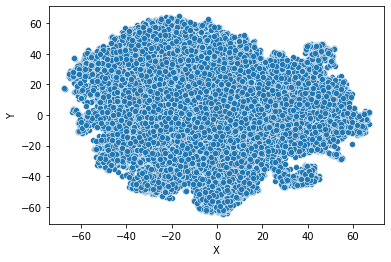

In [9]:
sns.scatterplot(x='X', y='Y', data=df_opentsne, legend=None)

In [ ]:
def single_model_and_plot(model, K, df, df_clusters, title, random_state=0):
    try:
        clustering = model(n_clusters=K, random_state=random_state).fit(df)
    except TypeError:
        clustering = model(n_clusters=K).fit(df)
    df_clusters['cluster'] = pd.Categorical(clustering.labels_)
    
    fig = plt.figure(figsize=(20,20))
    
#     plt.subplot(2,2,1)
#     sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_clusters, legend=None)
    plt.subplot(2,2,1)
    sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_clusters, legend=None)
#     plt.subplot(2,2,3)
#     sns.scatterplot(x='MDS_X', y='MDS_Y', hue='cluster', style='cluster', data=df_clusters, legend=None)

#     gpca.legend(bbox_to_anchor=(1, 1))
#     gtsne.legend(bbox_to_anchor=(1, 1))
#     gmds.legend(bbox_to_anchor=(1, 1))

#     gpca.set_title('PCA')
#     gtsne.set_title('T-SNE')
#     gmds.set_title('MDS')
#     fig.suptitle('{} with {}'.format(title, clustering), fontsize=16)
#     plt.show()

In [ ]:
single_model_and_plot(AgglomerativeClustering, K=20, df=scaled_data, df_clusters=df_tsne, 
                      title='Clustering on scaled data', random_state=None)

## Evaluation
We are going to use 7 different clustering models to evaluate the cluster perfomarmance with 3 different score metrics. 
There are 2 groups of clusters, one is those that don't have a number of cluster parameters and the other that does.

Models without K number of clusters as parameter:
- Affinity Propagation
- DBSCAN
- OPTICS

Models with K nummber of clusters as parameter:
- KMeans
- Birch
- Agglomerative
- Gaussian Mixture
- Spectral Clustering

For the latter, we are going to fit a model with k=2 to k=100 and score the clusters with the 3 differen metrics that are: Silhouette, Davis-Bouldin and Calinski-Harabasz.

In [ ]:
def models_without_k_scoring(data):
    """
    The models for this function are those models where there is no K number of cluster declaration such as Affinity Propagation,
    DBSCAN, OPTICS, etc.
    
    This function fits the input models to the input data and saves the models in a pickle form for later use due to 
    some of them will take hours to run.
    
    Silhouette, Davies-Bouldin and Calinski-Harabasz are calculated and output to a dictionary
    Models are saved to a /models folder, you need to create the folder in case you don't have it already.
    
    Parameters:
        - models (list): a list of tuples where each tuple is of the form ('model', model)
        - data (df): a dataframe with the scaled data
    Return:
        - dict_scores (dictionary): a dictionary with the scores processed
        - models (pickle): pickle models saved directly to your hard drive inside /models
    """
    models = [('AffinityPropagation', AffinityPropagation), ('DBSCAN', DBSCAN), ('OPTICS', OPTICS)]
    
    silhouette = []
    davies = []
    calinski = []
    dict_scores = {}
    
    for idx, model in enumerate(tqdm(models)):
        print(model[0])
        
        try:
            clstr = model[1](random_state=0).fit(data)
            labels = clstr.labels_
        except:
            clstr = model[1]().fit(data)
            labels = clstr.labels_   
        
        filename = 'models/{}_model.sav'.format(model[0])
        pickle.dump(clstr, open(filename, 'wb'))
        
        silhouette.append(silhouette_score(data, labels))
        davies.append(davies_bouldin_score(data, labels))
        calinski.append(calinski_harabasz_score(data, labels))
        
        dict_scores[model[0]] = {'silhouette':silhouette, 'davies':davies, 'calinski':calinski}
    
    with open('data/models_wo_k_scores.json', 'w') as outfile:
        json.dump(dict_scores, outfile, indent=2)
    
    return dict_scores

<AxesSubplot:xlabel='X', ylabel='Y'>

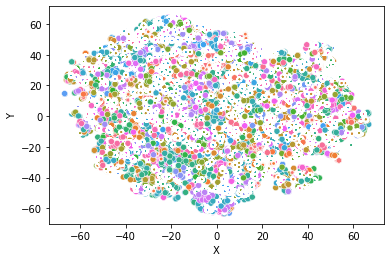

In [15]:
filename = 'AffinityPropagation_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

df_opentsne['cluster'] = pd.Categorical(loaded_model.labels_)
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)

<AxesSubplot:xlabel='X', ylabel='Y'>

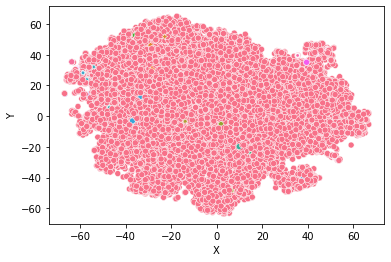

In [18]:
filename = 'OPTICS_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

df_opentsne['cluster'] = pd.Categorical(loaded_model.labels_)
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)

<AxesSubplot:xlabel='X', ylabel='Y'>

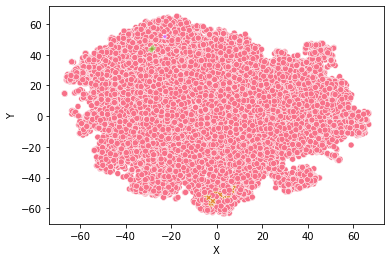

In [19]:
filename = 'DBSCAN_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

df_opentsne['cluster'] = pd.Categorical(loaded_model.labels_)
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)

[-1, 1, 0]
Categories (3, int64): [-1, 0, 1]

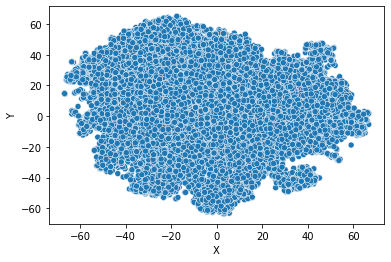

In [21]:
clstr = DBSCAN(metric='manhattan', eps=1).fit(feats_df)
df_opentsne['cluster'] = pd.Categorical(clstr.labels_)
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)
df_opentsne['cluster'].unique()

In [ ]:
def model_evaluation(data, max_k=5):
    """
    The models for this function are those models where there is a K number of cluster declaration such as KMeans, Birch,
    AgglomerativeCluster, etc.
    
    This function fits the input models to the input data.
    
    Silhouette, Davies-Bouldin and Calinski-Harabasz are calculated and output to a dictionary
    
    Parameters:
        - models (list): a list of tuples where each tuple is of the form ('model', model).
        - data (df): a dataframe with the scaled data.
        - max_5 (int): max number of k clusters to run for each model.
    Return:
        - dict_scores (dictionary): a dictionary with the scores processed.
    """
    models = [('KMeans', KMeans), ('Birch', Birch), ('Agglomerative', AgglomerativeClustering), 
              ('GaussianMixture', GaussianMixture)]
    
    cluster_size = range(2, max_k+1)
    dict_scores = {}
    
    #Plot setup
    cols = 3
    rows = len(models)
    y_size = 5*rows
    fig = plt.figure(figsize=(18,y_size))
    gs = plt.GridSpec(rows, cols)
    
    for idx, model in enumerate(tqdm(models)):
        silhouette = []
        davies = []
        calinski = []
        print(model[0])
        
        for k in tqdm(cluster_size):
            if model[0] in ('KMeans', 'SpectralClustering'):
                clstr = model[1](n_clusters=k, random_state=0).fit(data)
                labels = clstr.labels_
                
            elif model[0] in ('Agglomerative', 'Birch'):
                clstr = model[1](n_clusters=k).fit(data)
                labels = clstr.labels_
                
            elif model[0]=='GaussianMixture':
                clstr = model[1](n_components=k).fit(data)
                labels = clstr.predict(data)
   
            silhouette.append(silhouette_score(data, labels))
            davies.append(davies_bouldin_score(data, labels))
            calinski.append(calinski_harabasz_score(data, labels))
            
        dict_scores[model[0]] = {'silhouette':silhouette, 'davies':davies, 'calinski':calinski}
                   
        #Plot printing, each model in a row        
        i = 0
        j = idx
        plt.subplot(gs[j,i])
        plt.plot(cluster_size, silhouette, label='silhouette')
        plt.title(model[0]+' - Silhouette', fontsize=15)
        plt.xlabel("K", fontsize=12)
        plt.ylabel("Score", fontsize=12)
        
        plt.subplot(gs[j,i+1])
        plt.plot(cluster_size, davies, label='davies')
        plt.title(model[0]+' - Davies-Bouldin', fontsize=15)
        plt.xlabel("K", fontsize=12)
        
        plt.subplot(gs[j,i+2])
        plt.plot(cluster_size, calinski, label='calinski')
        plt.title(model[0]+' - Calinski-Harabasz', fontsize=15)
        plt.xlabel("K", fontsize=12)
    
    with open('data/models_with_k_scores.json', 'w') as outfile:
        json.dump(dict_scores, outfile, indent=2)
    
    plt.tight_layout()
    plt.savefig("images/ClusteringScores.svg")
    plt.show()
            
    return dict_scores

In [ ]:
##################################################################################################################
# STOP                                                                                                           #
# These functions will take 2+ hours to run with a 32Gb memory do not run unless totally necessary.                #
#                                                                                                                #
# model_evaluation() - was run previously and results are stored in data/models_with_k_scores.json and           #
# ClusteringScores.svg                                                                                           # 
#                                                                                                                #
# models_without_k_scoring() - was run previously and results are stored in data/models_wo_k_scores.json and     #
# models are stored in models/ as a pickle object                                                                #
##################################################################################################################
model_evaluation(feats_df, max_k = 100)
models_without_k_scoring(feats_df)

## Scores
From the plot and results above a couple of things can be said:
- Affinity Propagation does not scale well and specially with the size of the data is not recommended to use plus the scores are not promissing.
- Spectral Clustering was not even tried due to iterating over 100 different fittings would've taken days and also that this is only with 2% of the data.
- Davies-Boulding seems to be the best way to score our data, the lowest the score the better the clustering.
- The best number of cluster is around 20.


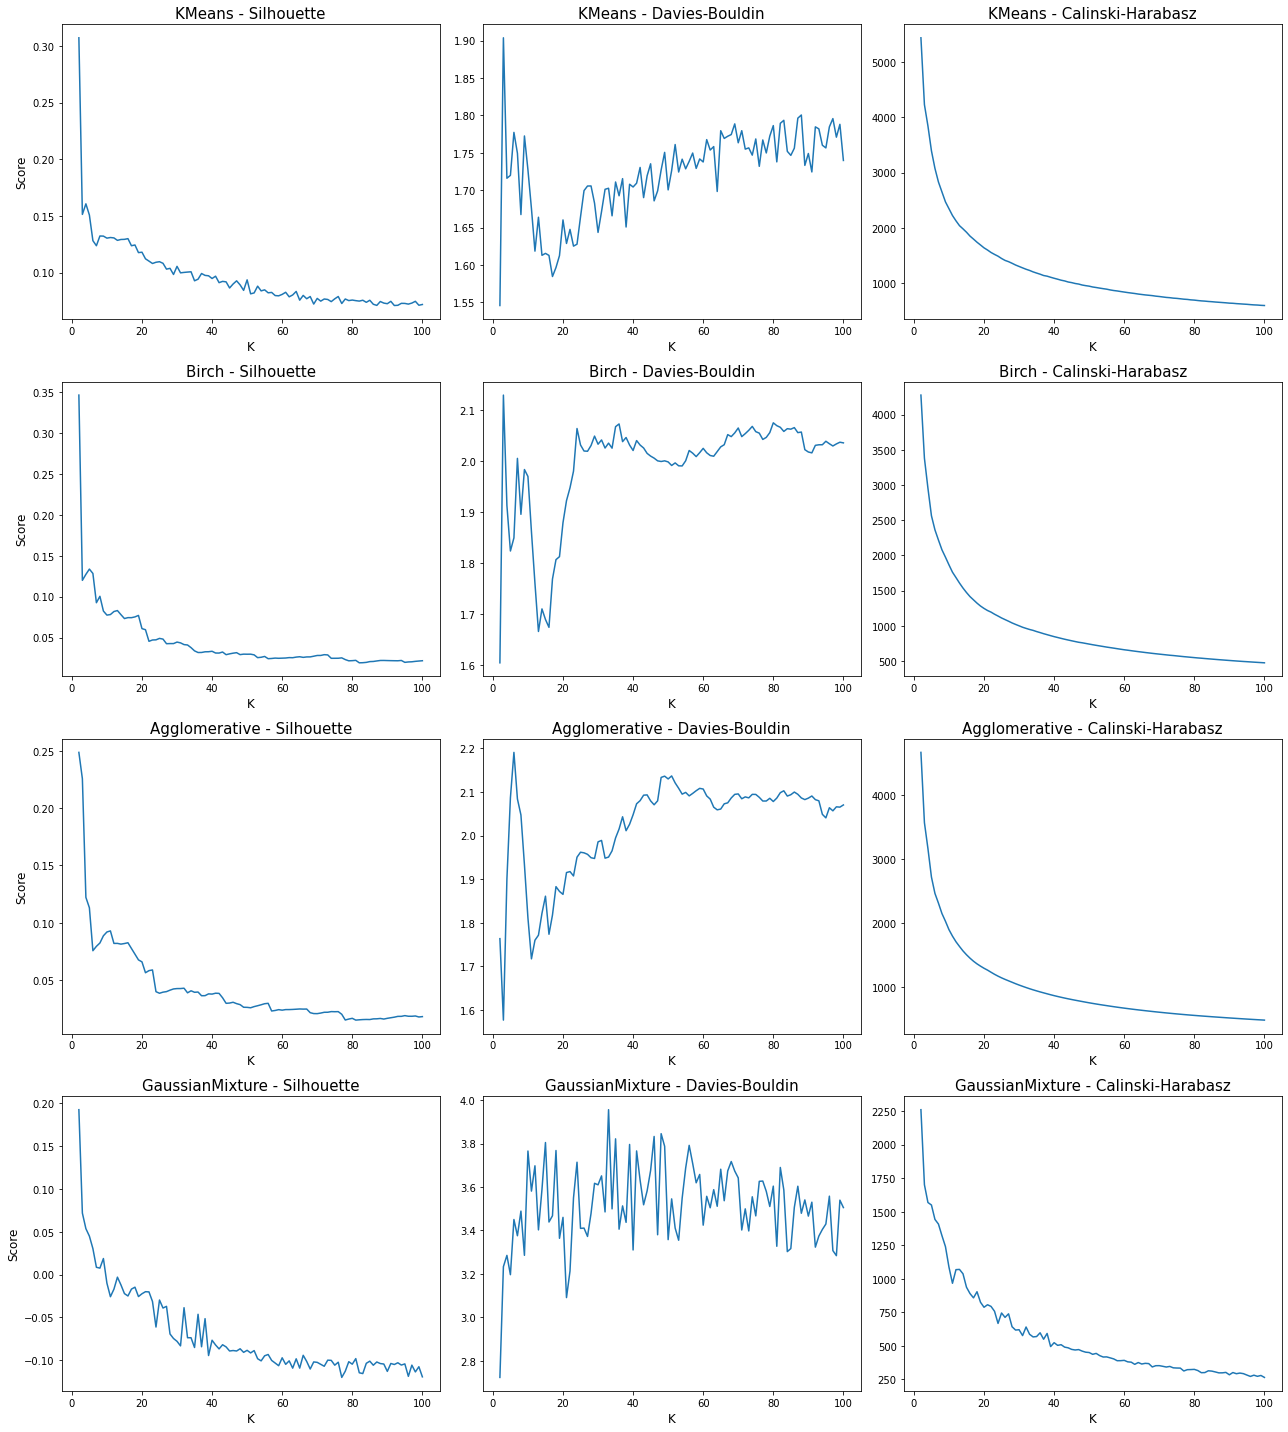

In [10]:
# Display scores plot from model_evaluation() function

# display(SVG(filename='images/ClusteringScores.svg')) # High def plot
Image(filename='images/ClusteringScores.png')

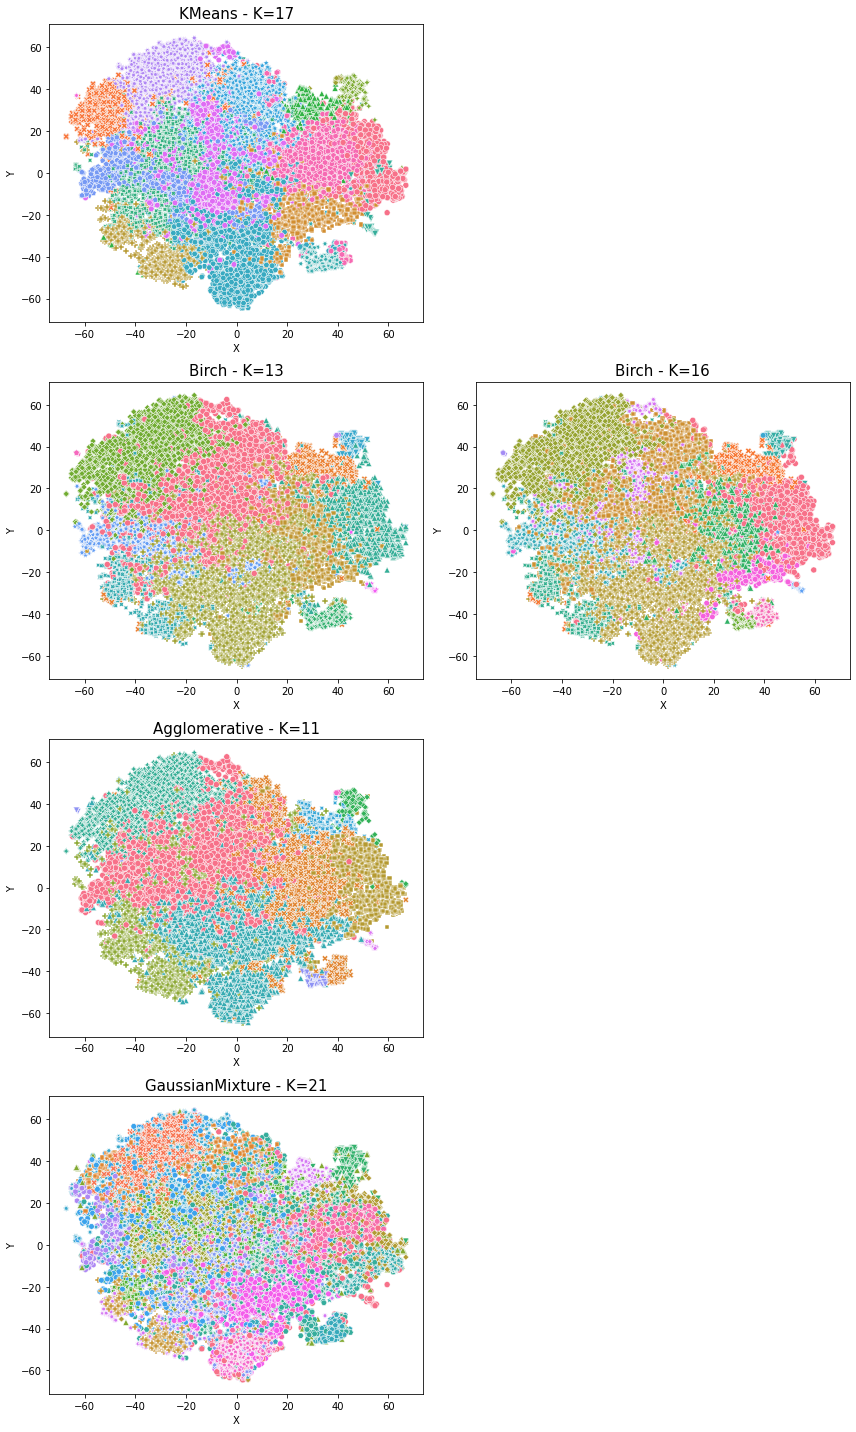

In [11]:
# Load scores from model_evaluation() function and extract the best K for each model based on Davies-Bouldin Score.
with open("data/models_with_k_scores.json", "r") as read_file:
    scores_dict = json.load(read_file)

# Extract lower Davies-Bouldin score for each model
KMeans_K = [np.asarray(scores_dict['KMeans']['davies']).argsort()[1]+2]
Birch_K = (np.asarray(scores_dict['Birch']['davies']).argsort()[1:3]+2).tolist()
Aglo_K = [np.asarray(scores_dict['Agglomerative']['davies']).argsort()[1]+2]
GausM_K = [np.asarray(scores_dict['GaussianMixture']['davies']).argsort()[1]+2]

models = [('KMeans', KMeans, KMeans_K), ('Birch', Birch, Birch_K), ('Agglomerative', AgglomerativeClustering, Aglo_K), 
          ('GaussianMixture', GaussianMixture, GausM_K)]

#Plot setup
cols = 2
rows = len(models)
y_size = 5*rows
fig = plt.figure(figsize=(12,y_size))
gs = plt.GridSpec(rows, cols)


# Fit and plot with best K
for idx, model in enumerate(models):
    i=0
    for k in model[2]:
        if model[0] in ('KMeans'):
            clstr = model[1](n_clusters=k, random_state=0).fit(feats_df)
            labels = clstr.labels_
                
        elif model[0] in ('Agglomerative', 'Birch'):
            clstr = model[1](n_clusters=k).fit(feats_df)
            labels = clstr.labels_
                
        elif model[0]=='GaussianMixture':
            clstr = model[1](n_components=k).fit(feats_df)
            labels = clstr.predict(feats_df)
        
        
        #Plot printing, each model in a row        
        
        j = idx
        plt.subplot(gs[j,i])
#         plt.plot(cluster_size, silhouette, label='silhouette')
        plt.title(model[0]+' - K={}'.format(k), fontsize=15)
#         plt.xlabel("K", fontsize=12)
#         plt.ylabel("Score", fontsize=12)
        
        df_opentsne['cluster'] = pd.Categorical(labels)
        sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)
        
        i+=1
plt.tight_layout()
plt.savefig("images/ClusteringOnTSNE.svg")
plt.show()    

In [12]:
KMeans_s = np.sort(np.asarray(scores_dict['KMeans']['davies']))[1]
Birch_s = np.sort(np.asarray(scores_dict['Birch']['davies']))[1]
Agglo_s = np.sort(np.asarray(scores_dict['Agglomerative']['davies']))[1]
GM_s = np.sort(np.asarray(scores_dict['GaussianMixture']['davies']))[1]
round(KMeans_s, 2), round(Birch_s, 2), round(Agglo_s, 2), round(GM_s, 2)

(1.58, 1.67, 1.72, 3.09)

## Model Selection
From these results, it can be seen, by visual inspection, how KMeans is the best model to create clusters, it is fascinating how one of the simplest and more straight forward model is the best performer here, this is good for our analysis and for our type of data given the fact that it can scale well for the size of our data (1M playlists).

This does not come as a surprise due to KMeans has the lowest Davies-Bouldin Score among all models, let's remeber that this number represents the average similarity of each cluster with a cluster most similar to it. The lower the average similarity is, the better the clusters are separated and the better is the result of the clustering performed. [Reference: https://ieeexplore.ieee.org/document/4766909]

Davies-Bouldin Scores:

- KMeans: 1.58
- Birch: 1.67
- Agglomerative: 1.72
- Gaussian Mixture: 3.09

## Cluster exploration
After clustering the playlist names are stracted to explore what type of music is inside each cluster, from this exploration, these are the top 10 most common playlist names for each cluster.

AS it can be seen, there are strong differences between some cluster but other cluster are really similar to each other.

The model developed is so powerful that out of 20,000 playlists it was able to distinguish and separate those playlists that contains stand up comedy and even more surprising, there are only 8, yes 8 playlist in the whole data set. This is mind blowing!!!!!!!!!

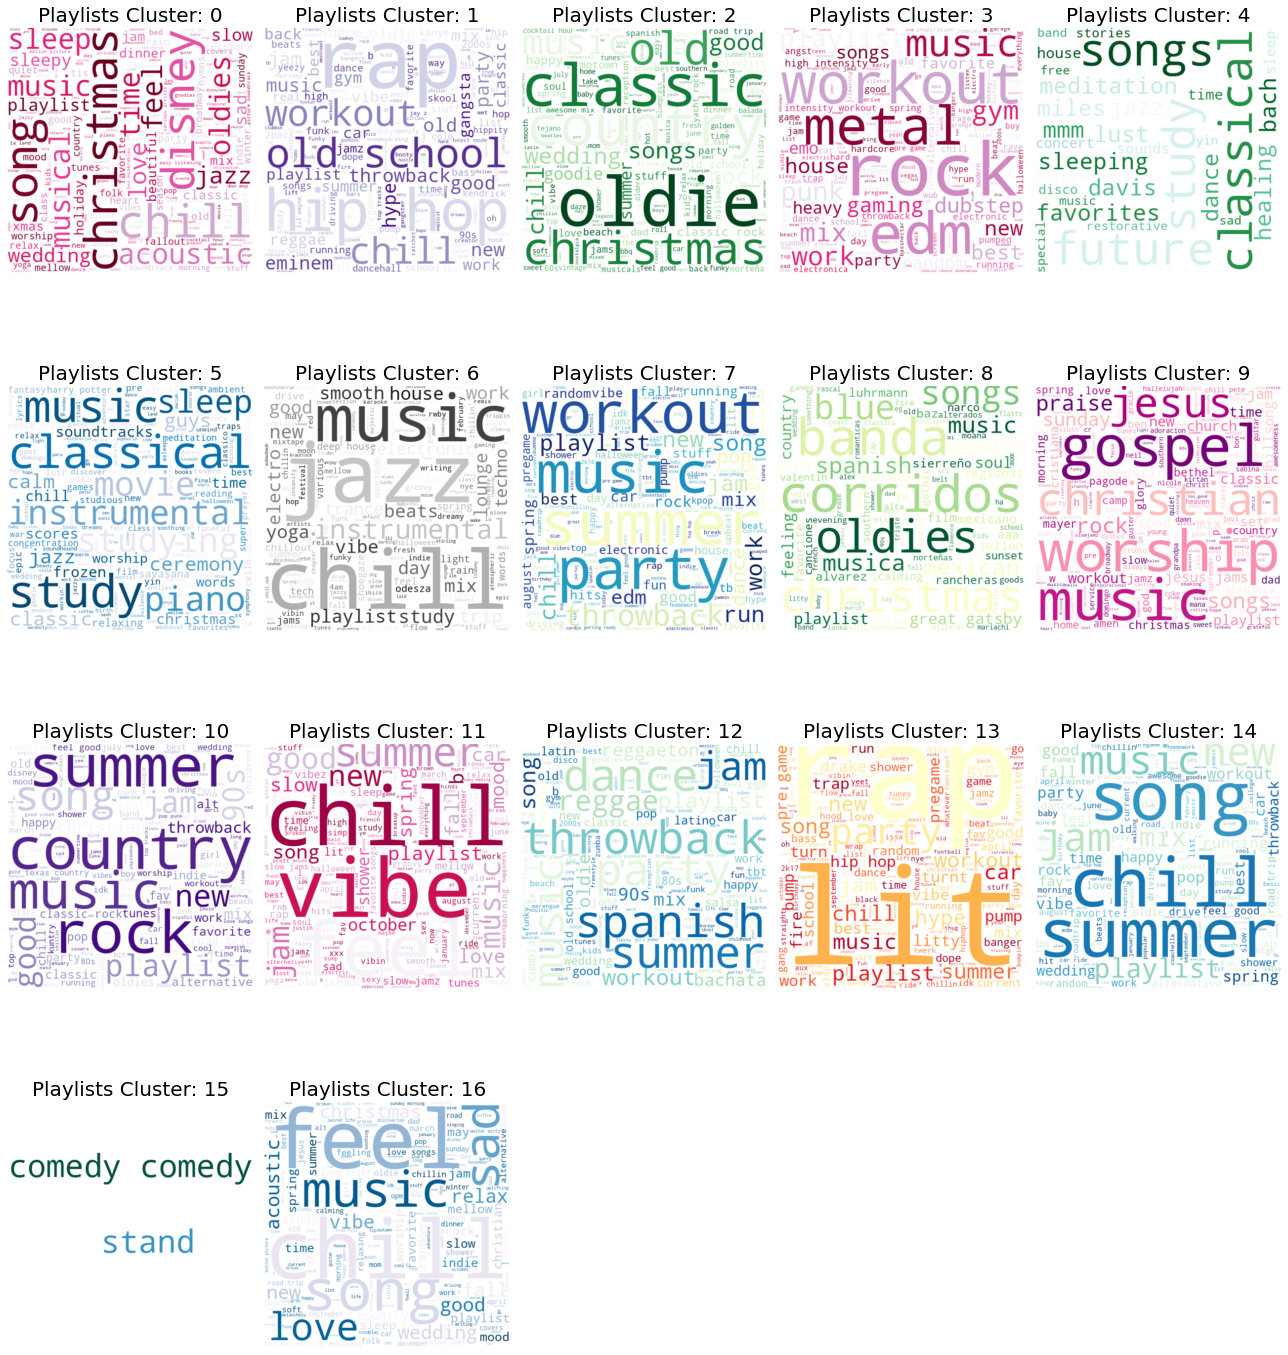

In [13]:
# Fit and pickle model. Uncomment to retrain
filename = 'models/KMeans_K17_20000_sample_model.sav'
# model = KMeans(n_clusters=17, random_state=0).fit(feats_df)
# pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))
top_playlists = []
# df_cluster = pd.DataFrame()

def cluster_exploration(model, df):
    df['name'] = df['name'].str.lower()
    df['cluster'] = pd.Categorical(model.labels_)
    categories = df['cluster'].cat.categories
    
    #Plot setup
    cols = 5
    rows = len(categories)//cols + len(categories)%cols
    y_size = 5*rows
    fig = plt.figure(figsize=(18,y_size))
    gs = plt.GridSpec(rows, cols)
    sequential =['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 
             'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    
    
    for idx, category in enumerate(categories):
        color = random.choice(sequential)
        df_cat = df[df['cluster']==category]
        text = ' '.join(df_cat["name"])
        df_cat = (df_cat.groupby('name')
                             .agg(count=('pid', 'count'))
                             .reset_index().sort_values(by=['count'], ascending=False)
                             .head(10)
                             .reset_index(drop=True))
#         df_cat.columns = pd.MultiIndex.from_product([['Cluster {}'.format(category)], df_cat.columns])
        df_cat.rename({'name': 'Cluster {}'.format(category)}, axis=1, inplace=True)
        top_playlists.append(df_cat[['Cluster {}'.format(category)]])

        #Plot printing, each model in a row        
        i = idx%cols
        j = idx//cols
        plt.subplot(gs[j,i])
        wc = WordCloud(background_color ='white',relative_scaling=0, width=500, height=500, colormap=color).generate(text)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title('Playlists Cluster: {}'.format(category), size=20)
    plt.tight_layout()
    plt.savefig("images/WordCloudPerCluster.svg")
    plt.show()  
    return pd.concat(top_playlists, axis=1)
top_playlists_df = cluster_exploration(model, df)

In [14]:
top_playlists_df

Cluster 0   Cluster 1           Cluster 2                  Cluster 3  \
0  christmas         rap              oldies                       rock   
1     disney     workout            classics                        edm   
2   musicals     hip hop             country                    workout   
3      sleep      eminem           christmas                      metal   
4      chill  old school        classic rock                        gym   
5     oldies     hip-hop               chill                    dubstep   
6   acoustic   chill rap  oldies but goodies                      house   
7       jazz       party              motown                       punk   
8      feels   throwback          old school                     gaming   
9        sad       chill                rock  my high-intensity workout   

        Cluster 4     Cluster 5      Cluster 6   Cluster 7          Cluster 8  \
0       classical     classical          chill     workout           corridos   
1           study  instrumental           jazz       party              banda   
2            bach         study    smooth jazz       chill          christmas   
3     meditation          sleep  instrumentals   throwback             oldies   
4         stories   study music   instrumental         edm             musica   
5         special      studying         lounge         run            country   
6  sleeping songs         piano     deep house  throwbacks            spanish   
7      sleep time       classic      chill out         pop          corridos    
8       sad songs          calm         techno     running  regional mexicano   
9    restorative       savasana          beats      summer             banda    

       Cluster 9      Cluster 10   Cluster 11  Cluster 12 Cluster 13  \
0        worship         country        chill  throwbacks        rap   
1         gospel        country         feels   throwback        lit   
2      christian            rock        vibes     spanish    workout   
3  worship music    classic rock          r&b       party      party   
4     jesus jams           chill         2017      reggae       hype   
5       worship        road trip    slow jamz     workout      chill   
6          jesus  summer country  chill vibes   reggaeton      litty   
7  worship songs             alt       mellow       dance       trap   
8         praise            work       summer     bachata       fire   
9    jesus music          summer    slow jams      latino        new   

  Cluster 14 Cluster 15 Cluster 16  
0      chill     comedy      chill  
1    running   stand up      feels  
2     summer        NaN      relax  
3        new        NaN      study  
4       jams        NaN  christmas  
5      party        NaN      sleep  
6    workout        NaN         <3  
7       2017        NaN        sad  
8        pop        NaN   acoustic  
9  feel good        NaN       love

## Music Recommendation based on Clustering
After clustering our data and exploring the results, we found out that the clusters make sense and they are good quality clusters.

The music recommendation we are going to do is based on clustering, we know that each cluster has similar music in it and this is key part of our recommender system because each cluster will serve as a hard boundary and this allow us to play with all the information for a given cluster.

By having a hard boundary, we can leverage that to use different metrics and different distances without the risk of recommending music that it is unrelated to the user's music taste and also alliviating the issue of always recommending music that it is too similar to the user's taste.

The procedure for this recommender system is to gather the user's favorite songs and compute the mean features, with our previously trained model, we can now predict in which cluster our user is going to fall, based on this, we will use the playlists belonging to that specific cluster and compute similarity.

There are 6 different ways to recommend with this approach that will use 3 different similarity metrics (euclidean, manhattan and cosine) where for each metric the top n most similar playlist can be suggested to the user or the top n most "disimilar" playlists. With the approach of most disimilar, we can recommend playlists that are far from the user but still within the hard boundaries of the cluster.



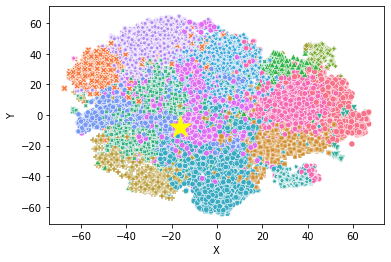

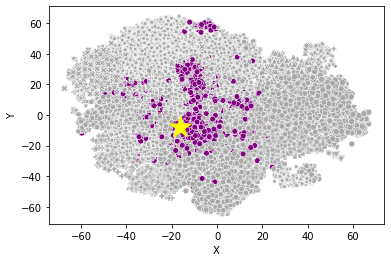

In [15]:
# Fit and pickle model. Uncomment to retrain
filename = 'models/KMeans_K17_20000_sample_model.sav'
# model = KMeans(n_clusters=17, random_state=0).fit(feats_df)
# pickle.dump(model, open(filename, 'wb'))

# Load model
model = pickle.load(open(filename, 'rb'))
df_opentsne['cluster'] = pd.Categorical(model.labels_)
df['cluster'] = pd.Categorical(model.labels_)


# Transform user fav songs to TSNE to plot in vector space
user_tsne = tsne_transformer.transform(scaled_y)[0]

user_cluster = model.predict(scaled_y)


sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)
plt.scatter(x=user_tsne[0], y=user_tsne[1], color='yellow', marker='*', s=500)
plt.show()

palette = {c:'purple' if c==user_cluster else 'darkgrey' for c in df.cluster.unique()}
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None, palette=palette)
plt.scatter(x=user_tsne[0], y=user_tsne[1], color='yellow', marker='*', s=500)
plt.show()

In [16]:
def get_top_n_playlists(model, feats_df, playlists, y, n, metric, similar, printing):
    """
    This function will compute the most similar or disimilar playlists given a target vector y which represents the mean
    features of the user's favorite songs. Similarity is calculated based on metrics such as Cosine, Manhattan, Euclidean, etc.
    Parameters:
        - model: Trained clustering model.
        - feats_df (dataframe): Dataframe with scaled data for all the training data
        - playlists (dictionary): Dictionary with all the playlists from the .json files
        - y (np.array): user's favorite songs scaled vector
        - n (int): top n playlists to retrieve
        - metric (str): metric to use, recommended 'cityblock', 'euclidean', 'cosine'.
        - similar (bool): whether to calculate most similar or most disimilar 
        - printing (bool): whether to print the results or not
    Output:
        - indices (np.array): indices of the top n playlists based on the feats_df dataframe
    
    """
    feats_df['cluster'] = pd.Categorical(model.labels_)
    user_cluster = model.predict(y)
    
    df_slice = feats_df[feats_df['cluster']==user_cluster[0]]
    df_slice = df_slice.drop(['cluster'], axis=1)
    indices = feats_df[feats_df['cluster']==user_cluster[0]].reset_index()['index'].to_numpy()
    
    scaled_data = df_slice.to_numpy()
    if similar:
        simi = cdist(scaled_data, y, metric=metric).argsort(axis=None)[:n]
    else:
        simi = cdist(scaled_data, y, metric=metric).argsort(axis=None)[-n:]
    simi = indices[simi]
     
    if printing:
        for idx in simi:
            print('Playlist: {}\tpid:{}'.format(playlists[idx]['name'], playlists[idx]['pid']))
            for song in playlists[idx]['tracks'][0:3]:
                print('Artist: {}\t Song:{}'.format(song['artist_name'], song['track_name']))
            print('\n')
    
    return simi
# get_top_n_playlists(model, feats_df, playlists, scaled_y, 3, 'cityblock', False, False)

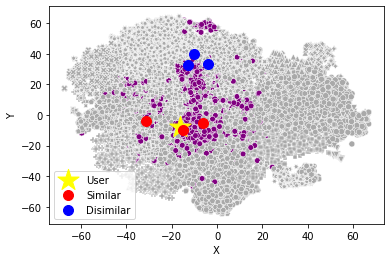

In [20]:
metrics = ['cityblock', 'euclidean', 'cosine']
similars = [('Similar', True), ('Disimilar', False)]
user_recommended_playlists = {}

for similar in similars:
    user_recommended_playlists[similar[0]] = {}
    for metric in metrics:
        user_recommended_playlists[similar[0]][metric] = get_top_n_playlists(model, feats_df, playlists, 
                                                                             scaled_y, 1, metric, similar[1], False)
        


similar_playlists = [user_recommended_playlists['Similar'][key][0] for key in user_recommended_playlists['Similar'].keys()]
disimilar_playlists = [user_recommended_playlists['Disimilar'][key][0] for key in user_recommended_playlists['Disimilar'].keys()]

palette = {c:'purple' if c==user_cluster else 'darkgrey' for c in df.cluster.unique()}
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None, palette=palette)
plt.scatter(x=user_tsne[0], y=user_tsne[1], color='yellow', marker='*', s=500, label='User')
plt.scatter(x='X', y='Y', data=df_opentsne.loc[similar_playlists], color='red', marker='o', s=100, label='Similar')
plt.scatter(x='X', y='Y', data=df_opentsne.loc[disimilar_playlists], color='blue', marker='o', s=100, label='Disimilar')
plt.legend()
plt.show()

# Similarity Approach

In [ ]:
scaled_data
feats_df.head()

# SKLearn Nearest Neighbors

In [ ]:
nbrs = NearestNeighbors(n_neighbors=3).fit(scaled_data)
NN = nbrs.kneighbors(scaled_y)
# closest_vec = sacaled_data[nbrs.kneighbors(np.atleast_2d(y))[1][0,0]]
# closest_vec

In [ ]:
df.loc[NN[1][0]]

In [ ]:
items = []
for track in playlists[2078]['tracks']:
    items.append(track['track_uri'].split("k:")[1])

In [ ]:
user_id = sp.current_user()['id']
sp.user_playlist_create('1276348384', 'Hello World!', description='First ever personal Machine Learning Playlist')


In [ ]:
sp.playlist_add_items('6N6cLTS50hzSQfOBgJdQoO',items=items[:99])

# Cosine Similarity

In [ ]:
['cosine', 'euclidian', 'mahalanobis', 'canberra', 'chebyshev', 'cityblock']

In [ ]:
# Run similarity and select top 3 closests
simi = cdist(scaled_data, scaled_y, metric='cityblock').argsort(axis=None)[0]
simi

In [ ]:
df.loc[simi]

In [21]:
playlists[simi]

NameError: name 'simi' is not defined

In [ ]:
items = []
for track in playlists[simi]['tracks']:
    items.append(track['track_uri'].split("k:")[1])

In [ ]:
sp.user_playlist_create('1276348384', 'Cosine Similarity', description='Playlist based on Cosine Similarity')

In [ ]:
sp.playlist_add_items('0ZKfsEOgoICmxUEt9KJf26',items=items[:99])

In [18]:
# Change the path to where your Spotify Million Playlist is located.
# The expected file structure is to have a data folder /data .csv files will be placed there.

path = 'data/spotify_million_playlist_dataset/data'

def loop_slices(path, num_slices=20):
    """
    Each slice is a .json file containing 1000 playlists i.e.: 1 slice is 1000 playlists 20 slices is: 20,000 playlists.
    Parameters:
        num_slices (int): Number of slices to return, max 1000.
        path (str): Path to the Spotify Million Playlist.
        
    Output:
        mpd_playlists (list): a list of dictionaries of all the playlists.
    """
    cnt=0
    mpd_playlists = []
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        cnt+=1
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            current_slice = json.loads(js)
            
            # Create a list of all playlists
            for playlist in current_slice['playlists']:
                mpd_playlists.append(playlist)


            if cnt == num_slices:
                break
    return mpd_playlists

In [19]:
playlists = loop_slices(path, num_slices=20)



mpd.slice.0-999.json
mpd.slice.1000-1999.json
mpd.slice.10000-10999.json
mpd.slice.100000-100999.json
mpd.slice.101000-101999.json
mpd.slice.102000-102999.json
mpd.slice.103000-103999.json
mpd.slice.104000-104999.json
mpd.slice.105000-105999.json
mpd.slice.106000-106999.json
mpd.slice.107000-107999.json
mpd.slice.108000-108999.json
mpd.slice.109000-109999.json
mpd.slice.11000-11999.json
mpd.slice.110000-110999.json
mpd.slice.111000-111999.json
mpd.slice.112000-112999.json
mpd.slice.113000-113999.json
mpd.slice.114000-114999.json
mpd.slice.115000-115999.json


In [ ]:
playlists[1]